In [ ]:
!unzip /content/drive/MyDrive/Dataset700_label.zip

Archive:  /content/drive/MyDrive/Dataset700_label.zip
   creating: Dataset700_label/
   creating: Dataset700_label/images/
  inflating: Dataset700_label/images/0001.jpg  
  inflating: Dataset700_label/images/0002.jpg  
  inflating: Dataset700_label/images/0003.jpg  
  inflating: Dataset700_label/images/0004.jpg  
  inflating: Dataset700_label/images/0005.jpg  
  inflating: Dataset700_label/images/0006.jpg  
  inflating: Dataset700_label/images/0007.jpg  
  inflating: Dataset700_label/images/0008.jpg  
  inflating: Dataset700_label/images/0010.jpg  
  inflating: Dataset700_label/images/0012.jpg  
  inflating: Dataset700_label/images/0013.jpg  
  inflating: Dataset700_label/images/0014.jpg  
  inflating: Dataset700_label/images/0015.jpg  
  inflating: Dataset700_label/images/0016.jpg  
  inflating: Dataset700_label/images/0017.jpg  
  inflating: Dataset700_label/images/0018.jpg  
  inflating: Dataset700_label/images/0019.jpg  
  inflating: Dataset700_label/images/0020.jpg  
  inflating: 

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K

In [ ]:
def load_and_resize_images(image_paths, size=(224, 224), is_mask=False):
    images = []
    for path in tqdm(image_paths, desc="Resizing masks" if is_mask else "Resizing images"):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE if is_mask else cv2.IMREAD_COLOR)
        img = cv2.resize(img, size)
        if not is_mask:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = np.expand_dims(img, axis=-1)
        images.append(img)
    return np.array(images, dtype='float32')

def load_pseudo_data(image_dir, mask_dir):
    X = sorted(glob(os.path.join(image_dir, "*.jpg")))
    Y = sorted(glob(os.path.join(mask_dir, "*.png")))

    train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.1, random_state=42)

    train_x = load_and_resize_images(train_x) / 255.0
    train_y = load_and_resize_images(train_y, is_mask=True) / 255.0

    val_x = load_and_resize_images(val_x) / 255.0
    val_y = load_and_resize_images(val_y, is_mask=True) / 255.0

    return (train_x, train_y), (val_x, val_y)


In [ ]:
def iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return intersection / (union + K.epsilon())

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def precision(y_true, y_pred):
    true_positive = K.sum(K.round(y_true * y_pred))
    predicted_positive = K.sum(K.round(y_pred))
    return true_positive / (predicted_positive + K.epsilon())

def recall(y_true, y_pred):
    true_positive = K.sum(K.round(y_true * y_pred))
    possible_positive = K.sum(K.round(y_true))
    return true_positive / (possible_positive + K.epsilon())

def accuracy(y_true, y_pred):
    correct_predictions = K.sum(K.cast(K.equal(K.round(y_true), K.round(y_pred)), dtype="float32"))
    total_predictions = K.cast(K.prod(K.shape(y_true)), dtype="float32")
    return correct_predictions / (total_predictions + K.epsilon())

def focal_loss(alpha=0.8, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1.0 - 1e-7)
        focal_weight = alpha * K.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true)
        return K.mean(focal_weight * K.binary_crossentropy(y_true, y_pred))
    return loss

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mixed_loss(y_true, y_pred):
    return focal_loss()(y_true, y_pred) + dice_loss(y_true, y_pred)

In [ ]:
if __name__ == "__main__":
    pseudo_path = r"/content/Dataset700_label/images"
    mask_dir = r"/content/Dataset700_label/predicted_masks"
    (train_x, train_y), (val_x, val_y) = load_pseudo_data(pseudo_path, mask_dir)

    from tensorflow.keras.models import load_model

    model = load_model(r"deeplabv3_plus&mobilenet_kvasir.h5",
                    custom_objects={
                        "mixed_loss": mixed_loss,
                        "accuracy": accuracy,
                        "precision": precision,
                        "recall": recall,
                        "dice_coefficient": dice_coefficient,
                        "iou": iou
                    })


    initial_lr = 0.0003
    decay_steps = 1000
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=initial_lr, decay_steps=decay_steps)
    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer,
                  loss=mixed_loss,
                  metrics=[accuracy, precision, recall, dice_coefficient, iou])

    history = model.fit(
        train_x, train_y,
        validation_data=(val_x, val_y),
        batch_size=4,
        epochs=10,
        verbose=1
    )

    model.save("/content/drive/MyDrivefine_tuned_on_pseudo.h5")

Resizing masks: 100%|██████████| 70/70 [00:00<00:00, 2478.36it/s]


Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 120s 342ms/step - accuracy: 0.9309 - dice_coefficient: 0.7160 - iou: 0.5667 - loss: 0.3632 - precision: 0.7474 - recall: 0.8061 - val_accuracy: 0.9421 - val_dice_coefficient: 0.7804 - val_iou: 0.6508 - val_loss: 0.2793 - val_precision: 0.7727 - val_recall: 0.8412
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 72s 105ms/step - accuracy: 0.9558 - dice_coefficient: 0.7886 - iou: 0.6600 - loss: 0.2571 - precision: 0.8133 - recall: 0.8591 - val_accuracy: 0.9528 - val_dice_coefficient: 0.7910 - val_iou: 0.6678 - val_loss: 0.3171 - val_precision: 0.9544 - val_recall: 0.7007
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.9628 - dice_coefficient: 0.8261 - iou: 0.7084 - loss: 0.2135 - precision: 0.8480 - recall: 0.8781 - val_accuracy: 0.9592 - val_dice_coefficient: 0.8136 - val_iou: 0.6968 - val_loss: 0.2367 - val_precision: 0.9145 - val_recall: 0.7802
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - accuracy: 0.9717 - dice_coefficie

OSError: [Errno 95] Unable to synchronously create file (unable to open file: name = '/content/drive/MyDrivefine_tuned_on_pseudo.h5', errno = 95, error message = 'Operation not supported', flags = 13, o_flags = 242)

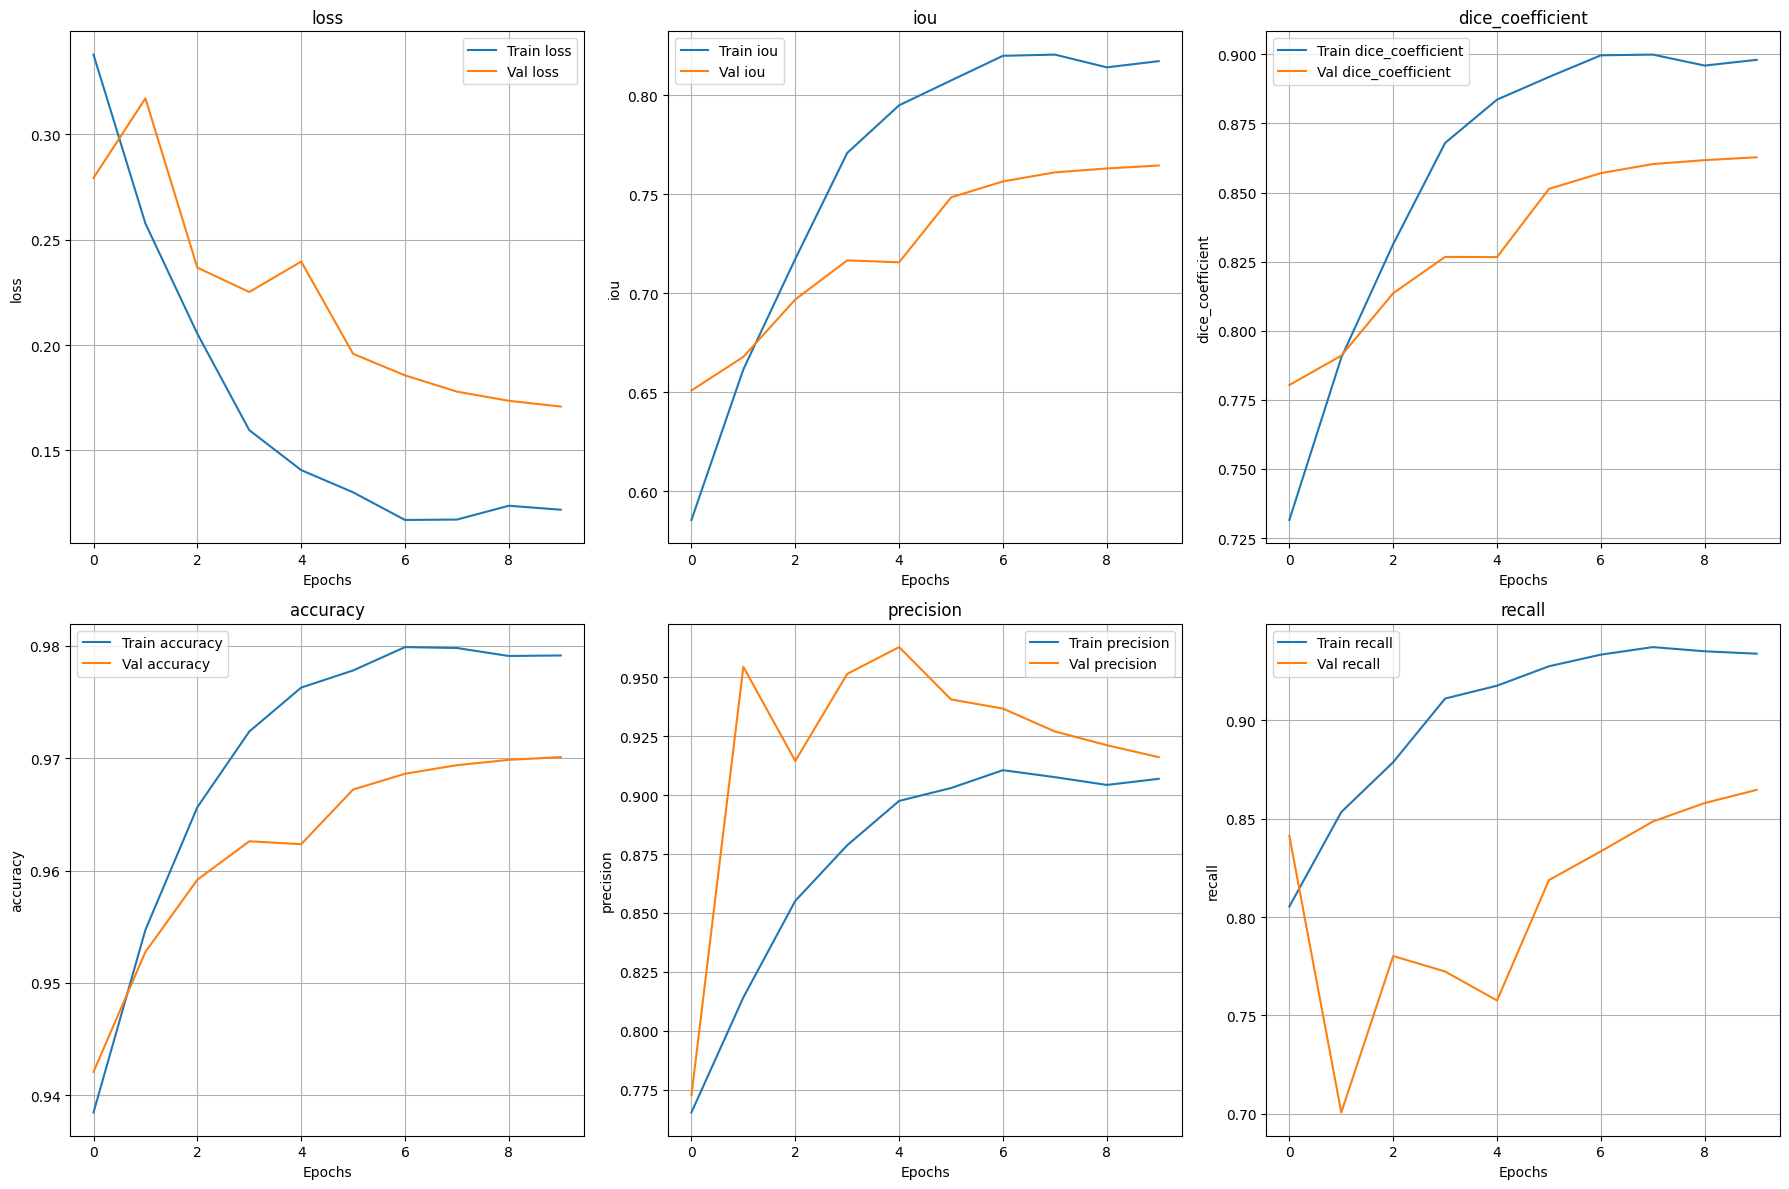

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    metrics = ["loss", "iou", "dice_coefficient", "accuracy", "precision", "recall"]

    plt.figure(figsize=(18, 12))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        plt.plot(history.history[metric], label=f"Train {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Val {metric}")
        plt.title(metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)
